In [2]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

### Let's start off by verifying that we can still handle single-photon processes in a simple way.

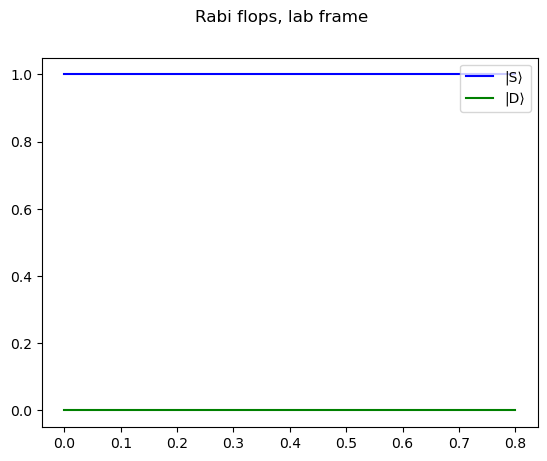

In [64]:
#two-level ion, S and D
my_ion = Ca40([("S1/2", -1/2), ("D5/2", -1/2)])
set_sublevel_alias!(my_ion, Dict("S" => ("S1/2", -1/2), "D" => ("D5/2", -1/2)))

#we actually will set number of motional modes to zero
νr = 4e6
νa = 1e6
#one laser
my_laser = Laser()
my_laser.k = ẑ
my_laser.ϵ = ẑ
my_laser.ϕ = 0

#configure trap
B = 4e-4
my_chain = LinearChain(ions=[my_ion], com_frequencies=(x=νr, y=νr, z=νa), vibrational_modes=(z=[1],))
my_trap = Trap(configuration=my_chain, B=B, Bhat=ẑ, δB=0, lasers=[my_laser])

#set laser wavelength and power, detuning small
Δ = 2e6 #laser detuning
my_laser.λ = transitionwavelength(my_ion,("S","D"),my_trap)
my_laser.Δ = Δ
Ω = 50e5 #rabi frequency - not an angular frequency!
Efield_from_rabi_frequency!(Ω, my_trap, 1, 1, ("S", "D"));

#don't use axial modes --> axial.N = 0
axial = my_trap.configuration.vibrational_modes.z[1]
axial.N = 0

# set initial state |S⟩ ⊗ |0⟩
ψi = my_ion["S"]
ρi_ions = dm(ψi)
ρi_axial = dm(fockstate(axial, 0))
ρi = ρi_ions ⊗ ρi_axial

J = one(dm(ψi)) ⊗ one(axial)
γ = 1

c = 299792458

#=  the unitary should be a vector of vectors of tuples so that
      u[j][k][1] is the kth "rotating" sublevel of the jth ion, and
      u[j][k][2] is the angular frequency of that rotation. 

    u does not need to have an element for every sublevel in the ion, but it shouldn't be larger than the ion's 
    electronic hilbert space. =#

#First, let's do the (silly) thing and try to simulate this in the lab frame, with a reasonable rwa cutoff.


nflops = 4
τ = nflops/Ω*1e6
steps = 1000
tspan = 0:τ/steps:τ

#=Set u to be a vector with dimension equal to the number of ions (1), and at each index it contains an empty
vector. This is silly to need to do of course, but no realistic simulation will want to use the lab frame.=#
u = [[]]

h = hamiltonian(my_trap, rwa_cutoff=1.01*Δ, lamb_dicke_order=2, u=u)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(my_trap,"S"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("Off-resonant Rabi flops, lab frame")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

#=We do not expect to see any dynamics here, because the lab frame Hamiltonian looks like this:
H(t) = Σᵢωᵢ|i⟩⟨i| + ΣₘΣₙΣₖ Ωₘₙₖ(e^{iνₘt}+e^{-iνₘt})(|n⟩⟨k|)
for i, n, and k>n indexing the eigenstates of the bare hamiltonian and m indexing lasers.
H(t) has time dependence on the order of THz (the laser frequencies) and this is much greater than the 
chosen rwa cutoff of 100 kHz.=#

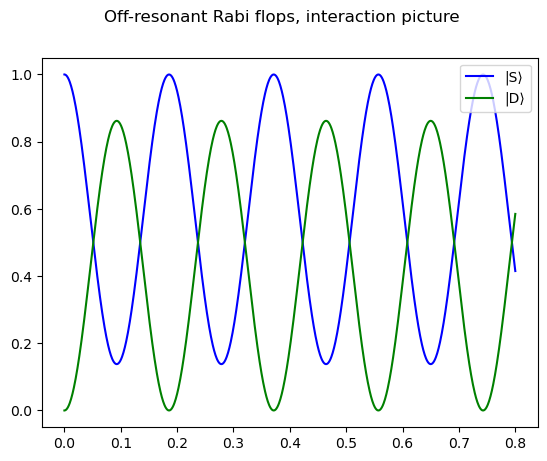

In [67]:
#=Let's go to the interaction picture so that we can handle our one-photon process. We can do it manually
or automatically. For starters, let's see how it is done manually.=#

#=This vector u contains two vectors, each of which associates a state with an angular frequency, and that
frequency is chosen to be -2π*(the energy of the state)=#
u = []
ωs = 2π * energy(my_ion, "S", B = B, ignore_starkshift = true)
ωd = 2π * energy(my_ion, "D", B = B, ignore_starkshift = true)
x = [(("S1/2",-1/2),-ωs),(("D5/2",-1/2),-ωd)]
push!(u,x)
h = hamiltonian(my_trap, rwa_cutoff=1.01*Δ, lamb_dicke_order=2, u=u)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(my_trap,"S"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("Off-resonant Rabi flops, interaction picture")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);
#=Set the rwa cutoff exceed the laser detuning and we will see the dynamics.
This is because the interaction picture DOES NOT eliminate time dependence entirely, it just leaves
elements rotating at the laser detuning. It is possible to make a transformation in this case which
TOTALLY eliminates time dependence, and this would let us see dynamics as long as rwa_cutoff>0! =#

### Let's try the same thing, but this time use the hamiltonian_interaction_picture function instead of providing the rotating frame manually.

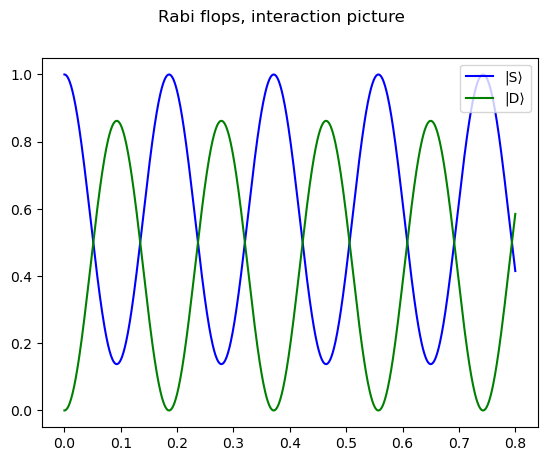

In [68]:
h_int = hamiltonian_interaction_picture(my_trap, rwa_cutoff=1.01*Δ, lamb_dicke_order=2)
nflops = 4
τ = nflops/Ω*1e6
steps = 1000
tspan = 0:τ/steps:τ
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h_int(t, ρ), [J], [J], [γ]))
slist = real(expect(ionprojector(my_trap,"S"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("Off-resonant Rabi flops, interaction picture")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

## Raman process??

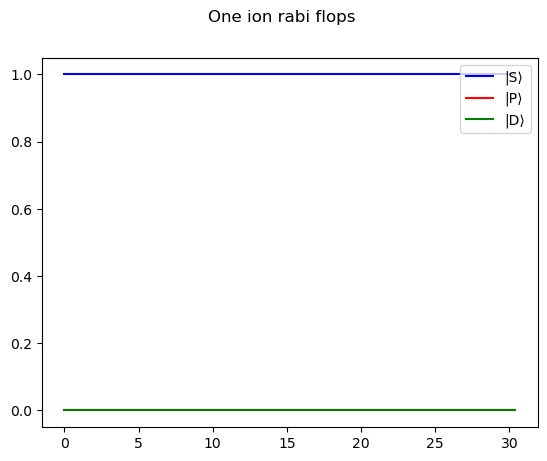

In [81]:
#=Now, consider a three-level (Λ) system comprised of two low-lying states |S⟩ and |D⟩, and a higher-energy state
|P⟩. |S⟩ ↔ |P⟩ and |P⟩ ↔ |D⟩ are dipole-allowed transitions, but |S⟩ ↔ |D⟩ is not. We may couple the two
low-lying states via two lasers, each of which couples one of the dipole-allowed transitions with a large
detuning. This is known as a Raman process.=#

my_ion = Ca40([("S1/2", -1/2), ("P3/2",-1/2),("D5/2", -1/2)])
set_sublevel_alias!(my_ion, Dict("S" => ("S1/2", -1/2), "P" => ("P3/2",-1/2),"D" => ("D5/2", -1/2)))
#one motional mode
νr = 4e6  #including this so that the chain can have com freqs
νa = 1e6
#two lasers
my_laser_1 = Laser()
my_laser_1.k = ẑ
my_laser_1.ϵ = ẑ
my_laser_1.ϕ = 0
my_laser_2 = Laser()
my_laser_2.k = ẑ
my_laser_2.ϵ = ẑ
my_laser_2.ϕ = 0

#configure trap
my_chain = LinearChain(ions=[my_ion], com_frequencies=(x=νr, y=νr, z=νa), vibrational_modes=(z=[1],))
my_trap = Trap(configuration=my_chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[my_laser_1,my_laser_2])

#set laser wavelength and power
Δ = 2π*300e6 #Absolute laser detuning is large compared to Ω₁, Ω₂
δ = 10e3 #two-photon detuning
my_laser_1.λ = transitionwavelength(my_ion,("S","P"),my_trap)
my_laser_1.Δ = Δ
my_laser_2.λ = transitionwavelength(my_ion,("D","P"),my_trap)
my_laser_2.Δ = Δ + δ

#Set Rabi frequencies
Ω₁ = 2π*1e6
Ω₂ = 2π*1e6
Efield_from_rabi_frequency!(Ω₁, my_trap, 1, 1, ("S", "P"));
Efield_from_rabi_frequency!(Ω₂, my_trap, 2, 1, ("D", "P"));

#again not using axial mode
axial = my_trap.configuration.vibrational_modes.z[1]
axial.N = 0

# set initial state |S⟩ ⊗ |0⟩
ψi = my_ion["S"]
ρi_ions = dm(ψi)
ρi_axial = dm(fockstate(axial, 0))
ρi = ρi_ions ⊗ ρi_axial

J = one(dm(ψi)) ⊗ one(axial)
γ = 1;

Ω_eff = π*Ω₁*Ω₂/Δ
nflops = 2
τ = nflops/Ω_eff*1e6
steps = 1000
tspan = 0:τ/steps:τ

#Let's go to the interaction picture!

h_int = hamiltonian_interaction_picture(my_trap, rwa_cutoff=.01, lamb_dicke_order=2)
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h_int(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(my_trap,"S"),ρt))
plist = real(expect(ionprojector(my_trap,"P"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))
nlist = real(expect(one(ρi_ions)⊗IonSim.number(axial),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("One ion rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

#=Now, we won't see any dynamics, because the lasers are far detuned from the transitions, so the interaction
picture isn't good enough - we would need an rwa cutoff of 300 MHz to see these dynamics!
But the two-photon detuning is small (the lasers are each detuned by the same amount), so maybe there is
another frame we could intelligently choose...?=#

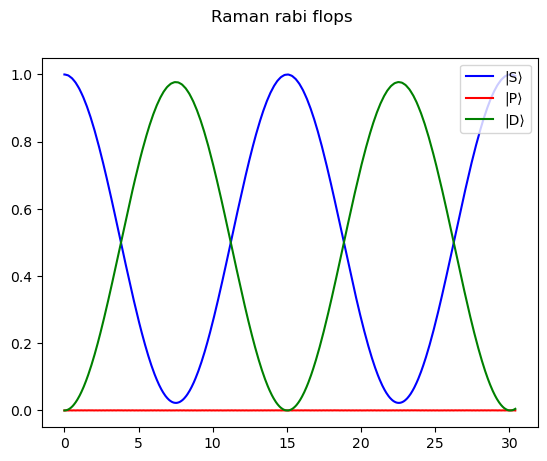

In [80]:
#= Now, we can try going into a better rotating frame to reduce the time dependence and recover the dynamics we
care about even after making the RWA with a small cutoff.=#

#This is the appropriate frame transformation for a Λ-system Raman process
ν1 = 2π*(c/my_laser_1.λ + my_laser_1.Δ)
ν2 = 2π*(c/my_laser_2.λ + my_laser_2.Δ)

ϕ1 = 2π*(my_laser_2.Δ - my_laser_1.Δ)/2
ϕ2 = ϕ1 + ν1
ϕ3 = ϕ2 - ν2

u = [[(("S1/2",-1/2),-ϕ1),(("P3/2",-1/2),-ϕ2),(("D5/2",-1/2),-ϕ3)]]

#=Since this unitary actually ELIMINATES time dependence in the Hamiltonian, we can make the rwa very small
and still see dynamics. The reason that rwa_cutoff=0 does not work is a rounding error! Keep in mind that
[rwa_cutoff] = Hz, so this is a cutoff of 1e-8 MHz.=#
h = hamiltonian(my_trap, rwa_cutoff=.01, lamb_dicke_order=2, u=u)

#I have not yet implemented the H0 piece of the rotating frame Hamiltonian, so I am doing it here by brute-force
h0 = (-ϕ1)*1e-6*dm(my_ion["S"])⊗dm(fockstate(axial, 0)) + (Δ)*1e-6*dm(my_ion["P"])⊗dm(fockstate(axial, 0)) + (ϕ1)*1e-6*dm(my_ion["D"])⊗dm(fockstate(axial, 0))

function h1(t,ρ)
    return h0 + h(t,ρ)
end

Ω_eff = π*Ω₁*Ω₂/Δ
nflops = 2
τ = nflops/Ω_eff*1e6
steps = 1000
tspan = 0:τ/steps:τ
_, ρt = timeevolution.master_dynamic(tspan, ρi, (t, ρ) -> (h1(t, ρ), [J], [J], [γ]))

slist = real(expect(ionprojector(my_trap,"S"),ρt))
plist = real(expect(ionprojector(my_trap,"P"),ρt))
dlist = real(expect(ionprojector(my_trap,"D"),ρt))

fig, (ax1) = plt.subplots(1)
fig.suptitle("Raman rabi flops")
ax1.plot(tspan,slist,color="blue",label="|S⟩")
ax1.plot(tspan,plist,color="red",label="|P⟩")
ax1.plot(tspan,dlist,color="green",label="|D⟩")
ax1.legend(loc=1);

#=And we see Rabi flopping between the |S⟩ and |D⟩ levels, while the |P⟩ level remains unpopulated,
as we expect.=#

In [84]:
pwd()

"/Users/justin/Julia/IonSim_test_rotating_frame"